<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_test_case(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf

# Imports for stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit


# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Please see MFD: comments and "to do" comments

# Generate switching data set

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(1000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

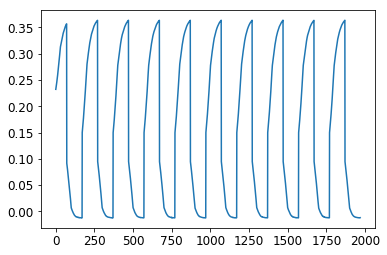

In [0]:
plt.plot(vols)

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

# prepare data for RNNs

In [0]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df.iloc[:split]
df_test = df.iloc[split:]

In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1566, 10, 1) (1566, 1, 1) (384, 10, 1) (384, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]


In [0]:
print(train_batch_size)

1566


# Define Alpha RNN models

In [0]:
class alphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. It uses a hidden layer for smoothing
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Walpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Walpha')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ualpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ualpha')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.balpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='balpha')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha_t = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='alpha_t')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Update alpha_t
        self.alpha_t = tf.sigmoid(tf.matmul(x_t, self.Walpha) + tf.matmul(h_tm1, self.Ualpha) + self.balpha)
        tf.add_to_collection('alpha_t', self.alpha_t)
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - self.alpha_t, h_tm1) + tf.multiply(self.alpha_t, h_proposal)
        
        return h_t

In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class simpleAlphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. 
       It uses a scalar smoothing
    
    
    Arguments
    ---------
    
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
        
    Todo
    --------
    1) how to constrain alpha to be in [0,1]?
    2) when hidden size >1, how to couple with scalar alpha?
    3) Should alpha be a vector of size hidden_size (is this better)?
    4) Get value of fitted alpha (see Diagnostics (visualize fitted values)) below
    4) Adapt the training to use early stopping (instead of fixed number of epoches)
    5) Compare with GRU, LSTM, simpleRNN
        
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='alpha')
        
        #tf.placeholder(dtype=tf.float64, shape=(None, 1), name='alpha')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - tf.tanh(self.alpha), h_tm1) + tf.multiply(tf.tanh(self.alpha), h_proposal)
        
        return h_t

## Training

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 5 #<= MFD: vary this between 1,2,5,10,20


In [0]:
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#regularized_loss = total_loss + regularization_penalty

In [0]:
def train(alpharnn, train_x, val_x, train_y, val_y, max_epochs=2000, batch_size=100):
    
  # Create a placeholder for the expected output
  expected_output_batch_train = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size,1), name='expected_output_batch_train')
  expected_output_train = tf.placeholder(dtype=tf.float64, shape=(train_x.shape[0], time_size,1), name='expected_output_train')
  #expected_output_test = tf.placeholder(dtype=tf.float64, shape(test_x.shape[0], time_size,1), name='expected_output_test')
  expected_output_val = tf.placeholder(dtype=tf.float64, shape=(val_x.shape[0], time_size,1), name='expected_output_val')

  #expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size), name='expected_output')

  # Just use quadratic loss
  train_batch_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_batch_train, 2)) / float(batch_size)
  train_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_train, 2)) / float(train_x.shape[0])
  validation_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(val_x.shape[0])

  #accuracy = tf.reduce_mean(tf.cast(validation_loss, tf.float64))

  # Use the Adam optimizer for training
  train_step = tf.train.AdamOptimizer().minimize(train_batch_loss)
    
  # Initialize the losses
  train_losses = []
  validation_losses = []
      
  # Initialize all the variables
  init_variables = tf.global_variables_initializer()
      
  #myNumpyData = np.ones([10,20])
  session.run(init_variables) # , {gru.Y: np.ones([20,20])})
 
  # Perform all the iterations
  patience_cnt = 0
  for epoch in range(max_epochs): # Compute the losses
        patience = 50
        min_delta = 0.000001
        

        total_batch = int(train_x.shape[0] / batch_size)
    
        for i in range(total_batch):
          
          batch_x = train_x[i*batch_size:(i+1)*batch_size]
          batch_y = train_y[i*batch_size:(i+1)*batch_size]
          session.run([train_step], feed_dict={alpharnn.input_layer: batch_x, expected_output_batch_train: batch_y})        
        train_loss_ = session.run(train_loss, feed_dict={alpharnn.input_layer: train_x, expected_output_train: train_y})
        validation_loss_ = session.run(validation_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y})

        # Log the losses
        train_losses += [train_loss_]
        validation_losses += [validation_loss_]
          #mse = mean_squared_error(train_losses,validation_losses) <= this is wrong! 
          # I know...it's original values and the predicted values
        #keras uses: model.compile(loss='mean_squared_error', optimizer='sgd') 
        # and: keras.losses.mean_squared_error(y_true, y_pred)
        y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
        MSE = np.square(np.subtract(y_test_reg,y_predicted)).mean()

        if epoch % 50 == 0: 
            print('Epoch ', epoch, '/', max_epochs, ': ',
                      "\tTraining Loss: {:.5f}".format(train_loss_),
                      "\tValidation Loss: {:.5f}".format(validation_loss_),
                      "\tloss:", MSE                      

                 )
        if epoch > 0 and (validation_losses[epoch-1] - validation_losses[epoch]) > min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
            #print(patience_cnt)
        if patience_cnt > patience:
            print("Early stopping")
            break
  saver = tf.train.Saver()
  saved_path = saver.save(session, './saved_variable')          
  #print('\nMSE: ',mse)
  plt.plot(train_losses, '-b', label='Train loss')
  plt.plot(validation_losses, '-r', label='Validation loss')
  plt.legend(loc=0)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()
  return alpharnn     

Epoch  0 / 2000 :  	Training Loss: 0.21214 	Validation Loss: 0.21935 	loss: 0.043869286465960264
Epoch  50 / 2000 :  	Training Loss: 0.02900 	Validation Loss: 0.02864 	loss: 0.005727380112561535
Epoch  100 / 2000 :  	Training Loss: 0.01605 	Validation Loss: 0.01483 	loss: 0.002965762081088544
Epoch  150 / 2000 :  	Training Loss: 0.01487 	Validation Loss: 0.01354 	loss: 0.0027070585072671736
Epoch  200 / 2000 :  	Training Loss: 0.01475 	Validation Loss: 0.01339 	loss: 0.002677211248221688
Epoch  250 / 2000 :  	Training Loss: 0.01471 	Validation Loss: 0.01335 	loss: 0.0026694069428026147
Early stopping


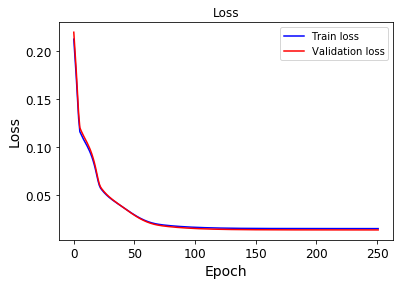

In [30]:
session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 


train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg)

In [0]:
y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

       

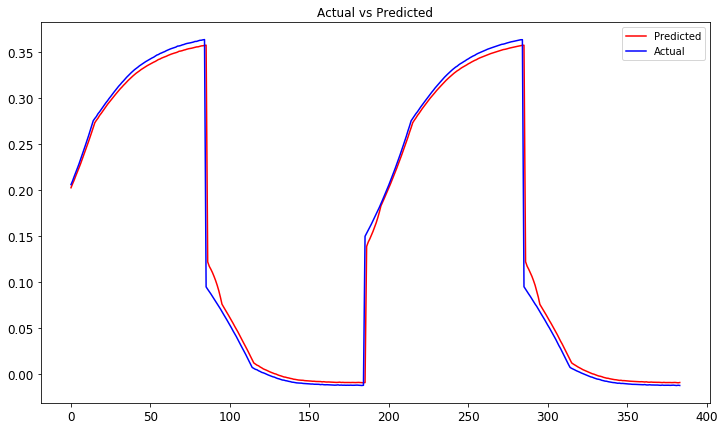

In [32]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()


## Cross-Validation

In [0]:
# Create a new instance of the alpha_RNN model
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)

alpharnn_cv = alphaRNN(input_dimensions, hidden_size)

In [0]:
# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) #prediction

In [0]:
def cross_validate(session, split_size):

  results = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    train(alpharnn, train_x, val_x, train_y, val_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results


TRAIN: (261,) TEST: (261,)
Epoch  0 / 1500 :  	Training Loss: 0.32156 	Validation Loss: 0.19526 	loss: 0.050928354721019725
Early stopping


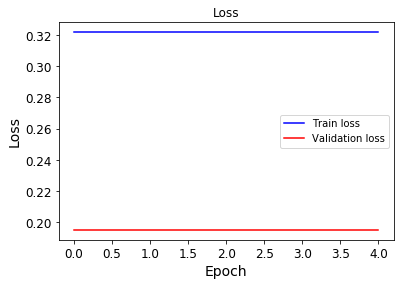

TRAIN: (522,) TEST: (261,)
Epoch  0 / 1500 :  	Training Loss: 0.24843 	Validation Loss: 0.20113 	loss: 0.04898921869677806
Epoch  50 / 1500 :  	Training Loss: 0.17213 	Validation Loss: 0.13944 	loss: 0.03424028716588842
Epoch  100 / 1500 :  	Training Loss: 0.11162 	Validation Loss: 0.10478 	loss: 0.022932487871517217
Epoch  150 / 1500 :  	Training Loss: 0.09700 	Validation Loss: 0.09028 	loss: 0.019896481554482655
Epoch  200 / 1500 :  	Training Loss: 0.06277 	Validation Loss: 0.05472 	loss: 0.012579869012622268
Epoch  250 / 1500 :  	Training Loss: 0.04840 	Validation Loss: 0.04425 	loss: 0.009651362130822221
Epoch  300 / 1500 :  	Training Loss: 0.04230 	Validation Loss: 0.03929 	loss: 0.008410701013379197
Epoch  350 / 1500 :  	Training Loss: 0.03628 	Validation Loss: 0.03345 	loss: 0.007136270429829184
Epoch  400 / 1500 :  	Training Loss: 0.03068 	Validation Loss: 0.02813 	loss: 0.005957281915859583
Epoch  450 / 1500 :  	Training Loss: 0.02625 	Validation Loss: 0.02396 	loss: 0.0050301

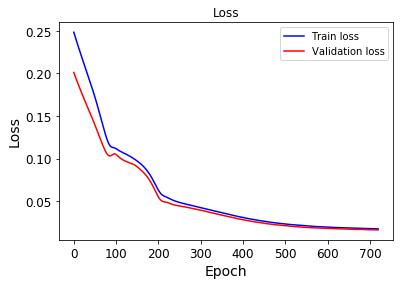

TRAIN: (783,) TEST: (261,)
Epoch  0 / 1500 :  	Training Loss: 0.22779 	Validation Loss: 0.30141 	loss: 0.047988873616355364
Epoch  50 / 1500 :  	Training Loss: 0.15511 	Validation Loss: 0.20351 	loss: 0.03296258579469904
Epoch  100 / 1500 :  	Training Loss: 0.10875 	Validation Loss: 0.11986 	loss: 0.022882920475841603
Epoch  150 / 1500 :  	Training Loss: 0.09469 	Validation Loss: 0.10439 	loss: 0.019924528574122063
Epoch  200 / 1500 :  	Training Loss: 0.06069 	Validation Loss: 0.07051 	loss: 0.01270717376211522
Epoch  250 / 1500 :  	Training Loss: 0.04582 	Validation Loss: 0.04993 	loss: 0.009419343890680979
Epoch  300 / 1500 :  	Training Loss: 0.03860 	Validation Loss: 0.03961 	loss: 0.00785192863440218
Epoch  350 / 1500 :  	Training Loss: 0.03237 	Validation Loss: 0.03304 	loss: 0.006513489058344393
Epoch  400 / 1500 :  	Training Loss: 0.02736 	Validation Loss: 0.02719 	loss: 0.00544385849967073
Epoch  450 / 1500 :  	Training Loss: 0.02368 	Validation Loss: 0.02301 	loss: 0.004644492

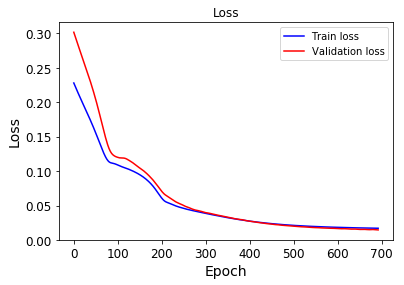

TRAIN: (1044,) TEST: (261,)
Epoch  0 / 1500 :  	Training Loss: 0.22445 	Validation Loss: 0.20602 	loss: 0.04382728291930123
Epoch  50 / 1500 :  	Training Loss: 0.10911 	Validation Loss: 0.10932 	loss: 0.02260087337725258
Epoch  100 / 1500 :  	Training Loss: 0.05867 	Validation Loss: 0.05932 	loss: 0.011883608300511276
Epoch  150 / 1500 :  	Training Loss: 0.03545 	Validation Loss: 0.03888 	loss: 0.007178086711383189
Epoch  200 / 1500 :  	Training Loss: 0.02489 	Validation Loss: 0.02849 	loss: 0.004951683667111426
Epoch  250 / 1500 :  	Training Loss: 0.01955 	Validation Loss: 0.02388 	loss: 0.003854335552810399
Epoch  300 / 1500 :  	Training Loss: 0.01713 	Validation Loss: 0.02178 	loss: 0.0033488310519832125
Epoch  350 / 1500 :  	Training Loss: 0.01590 	Validation Loss: 0.02068 	loss: 0.003082653057560906
Epoch  400 / 1500 :  	Training Loss: 0.01518 	Validation Loss: 0.02004 	loss: 0.002930626696249201
Early stopping


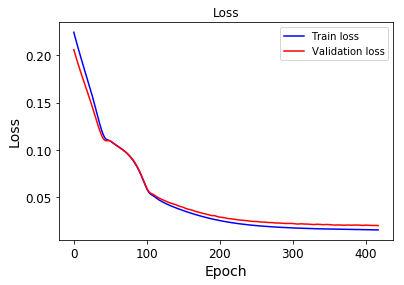

TRAIN: (1305,) TEST: (261,)
Epoch  0 / 1500 :  	Training Loss: 0.23441 	Validation Loss: 0.17770 	loss: 0.04648130285010524
Epoch  50 / 1500 :  	Training Loss: 0.11156 	Validation Loss: 0.11094 	loss: 0.023022110612173116
Epoch  100 / 1500 :  	Training Loss: 0.06254 	Validation Loss: 0.05608 	loss: 0.012647860779454397
Epoch  150 / 1500 :  	Training Loss: 0.03710 	Validation Loss: 0.03478 	loss: 0.007351290540321383
Epoch  200 / 1500 :  	Training Loss: 0.02664 	Validation Loss: 0.02466 	loss: 0.005175116820301312
Epoch  250 / 1500 :  	Training Loss: 0.02107 	Validation Loss: 0.01914 	loss: 0.003991647334639945
Epoch  300 / 1500 :  	Training Loss: 0.01839 	Validation Loss: 0.01654 	loss: 0.0034222839898491435
Epoch  350 / 1500 :  	Training Loss: 0.01703 	Validation Loss: 0.01523 	loss: 0.00311431225671919
Epoch  400 / 1500 :  	Training Loss: 0.01628 	Validation Loss: 0.01451 	loss: 0.002948822096241317
Early stopping


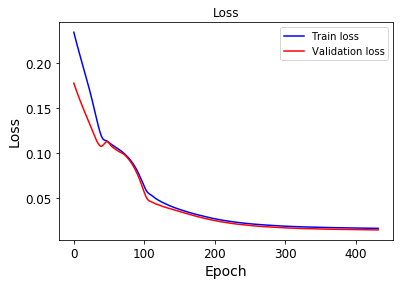

Cross-validation result: [0.19525826789021342, 0.016159588473740178, 0.014605330822718908, 0.01960442567695228, 0.01420432375209637]


In [0]:
with tf.Session() as session:
 
  #saved_path = saver.save(session, './saved_variable')
  result = cross_validate(session, 5)
  

  print('Cross-validation result: %s' % result)

  #print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
print(train_losses[0][1])

## Diagnostics (visualize fitted values)

In [0]:

# MFD: It would be good to visualize the amount of smoothing, but I get an error
#alpha=session.run(alpharnn.alpha, feed_dict={alpharnn.input_layer: x_test_reg})

In [0]:
#plt.plot(alpha_t[:,n_steps-1,1], 'red')
#pplt.plot(y_test_reg.flatten(),'blue')

# Comparsion with Keras GRU, RNN, LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

MFD: batch size must match that used for alpha_RNN when comparing LSTM



### LSTM


In [0]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=500, callbacks=[es])

### RNN

In [0]:

rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=500, callbacks=[es])

### GRU

In [0]:
gru_model = Sequential()
gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

gru_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=500, callbacks=[es])

### Prediction

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

In [0]:
# compare with the trained plain GRU

In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

### Model Performance

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(y_predicted_ar, color='green', label="alpha RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
# calculate mean squared error of the plain LSTM
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], lstm_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], validation_losses[:, 0])
print(MSE_test)